## Import labels

In [3]:
import numpy as np
import spectral
from PIL import Image
import os
import matplotlib.pyplot as plt
import utils
import tifffile
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist
from os import listdir

In [4]:
data_dir = './data/'
img_name = listdir(data_dir) 
print(img_name)

['2019_04_18_M', '2019_05_03_M', '2019_05_08_M', '2019_05_18_M', '2019_05_28_M', '2019_06_07_M', 'label']


In [50]:
bands = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']

# transorfm the dict into an array
def from_dict_to_array(img_bands):
    band_arrays = []
    for e in bands:
        band_arrays.append(img_bands[e])
    return band_arrays

def get_dataset(data_dir, bands):
    labels = []
    data = []
    img_name = listdir(data_dir)
    sizes= []
    for e in img_name : 
        if e!='label':
            data_im, label_im = utils.get_batch(bands, e, all = False)
            sizes.append(data_im.shape[0:2])
            flatten_labels = label_im.flatten()
            flatten_data = [data_im[:,:,i].flatten() for i in range(len(bands))]
            a_concat = np.zeros((flatten_data[0].shape[0],len(bands)))
            for i in range(0, len(flatten_data)):
                a_concat[:,i] = flatten_data[i]
            for k in range(flatten_data[0].shape[0]):
                data.append(a_concat[k])
            for e in flatten_labels:
                labels.append(e)

    return data, labels, sizes
            

In [47]:
## get images' directory

bands = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']


label_dir = './data/label/'
end = '_label.tif'
# img1 = '2019_04_18_M'
img1 = '2019_05_03_M'
img1_lab_path = label_dir + img1 + end
img1_lab = tifffile.imread(img1_lab_path)
print(img1_lab.shape)
img_bands = utils.get_band(bands,img1)
band_arrays = from_dict_to_array(img_bands)
print(band_arrays[0].shape)

(90, 183, 3)
(90, 183)


In [51]:
bands = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']
data, labels, sizes = get_dataset(data_dir, bands)

In [17]:
#print(len(data))
#print(len(labels))
#m,n= labels[1].shape
#plt.imshow(data[1][:,:,1])

## KNN Classifier

#### Create Training and Testing datasets

In [20]:
from sklearn.model_selection import train_test_split
## We split the dataset into a training and testing set with a ration of 30%

X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size=0.3,random_state=42, stratify=labels)

In [36]:
print(" Taille Training Set = " + str(len(y_train))+ "\n Taille Testing Set = " + str(len(y_test)))

 Taille Training Set = 66099
 Taille Testing Set = 28329


#### Finding the best K 

In [37]:
#import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 

#### Plot the result

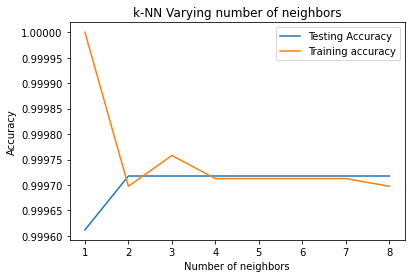

In [38]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

#### Create the best Classifier using the best k

In [40]:
#Setup a knn classifier with k neighbors
best_k= 3
knn = KNeighborsClassifier(n_neighbors=3)

#Fit the model
knn.fit(X_train,y_train)

best_acc = int(knn.score(X_test,y_test) *100) /100

print("The best accuracy is = " + str(best_acc)) ## Les resulats sont à prendre avec des pincettes


The best accuracy is = 0.99


Meme si les resultats semblent très bons ce n'est pas forcément le cas. En effet, la proportion de  pixels qui ne sont pas du plastique est bien bien plus faible que la proportion de plastique ce qui fausse grandement les resultats. 

#### Let's Plot the images 

In [61]:
y_predict = knn.predict(data)

In [77]:
cnt_TP = 0
cnt_FP = 0
cnt_FN = 0
cnt_Positifs = 0
for i in range(len(y_predict)) :
    if y_predict[i] == 1 :
        if labels[i] == 1 :
            cnt_TP+=1
        else :
            cnt_FP+= 1
    if labels[i] == 1 :
        cnt_Positifs+=1
        if y_predict[i] != 1 :
            cnt_FN+=1

In [113]:
print("Nombre de Pixels Vrais Positifs = " + str(cnt_TP))
print("Nombre de Pixels Faux Positifs = " + str(cnt_FP))
print("Nombre de Pixels Faux Negatifs = " + str(cnt_FN))
print("Nombre de Pixels Positifs = " + str(cnt_Positifs))

Nombre de Pixels Vrais Positifs = 5
Nombre de Pixels Faux Positifs = 1
Nombre de Pixels Faux Negatifs = 23
Nombre de Pixels Positifs = 28


On remarque ici qu'il y 28 pixels de plastique et que seulement 5 sont identifiés par le classifer ... 

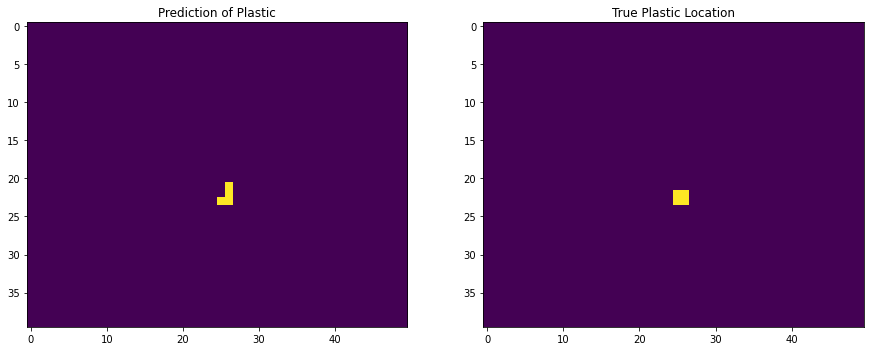

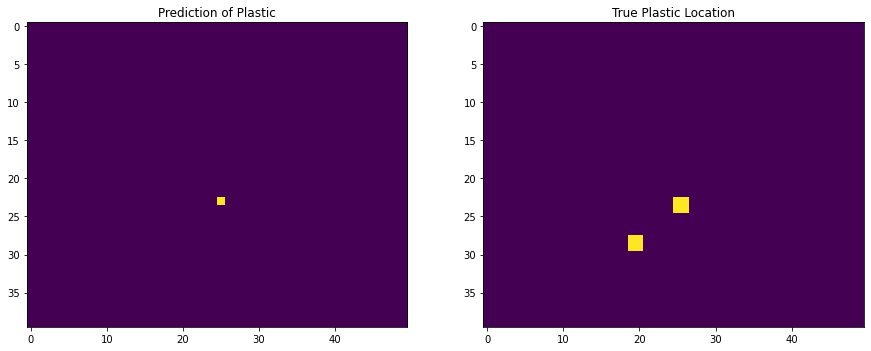

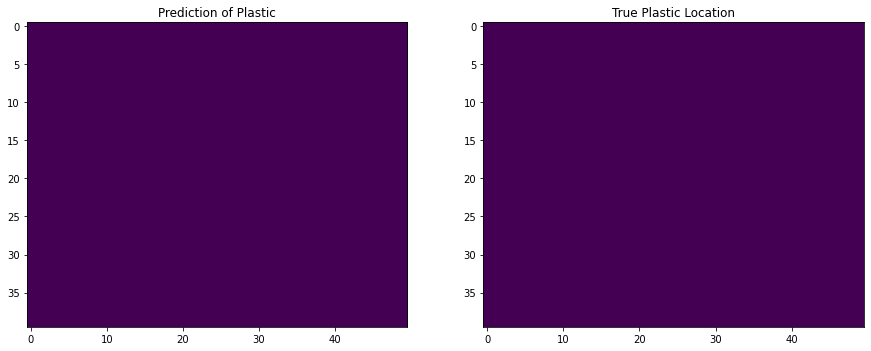

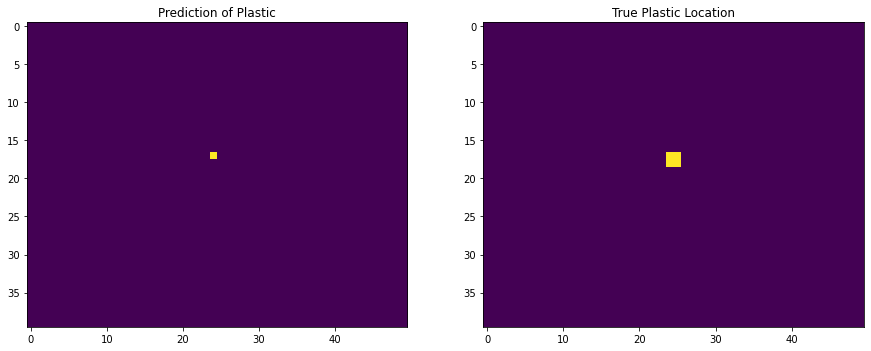

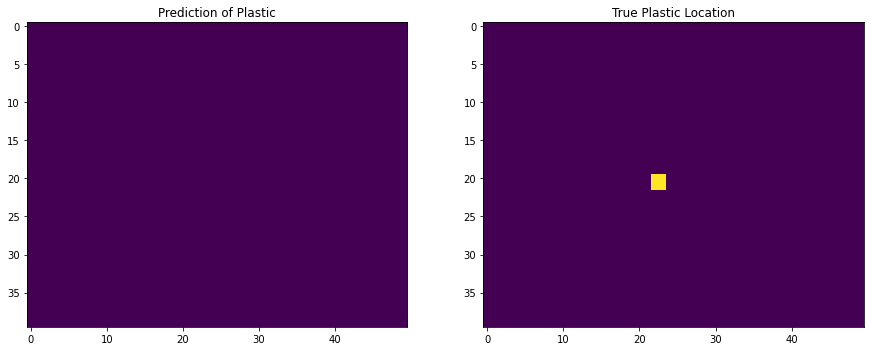

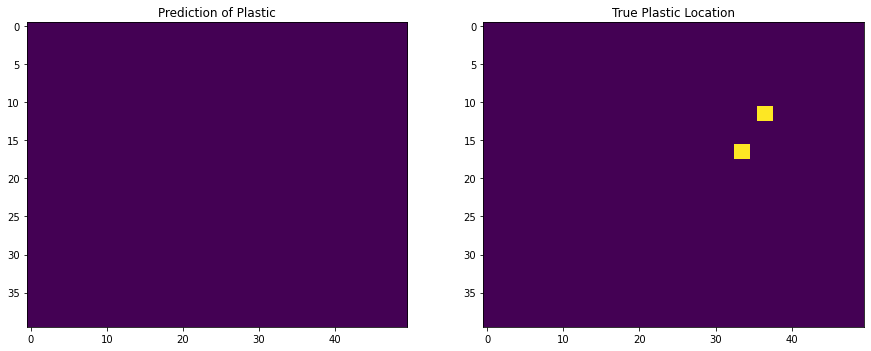

In [119]:
i = 0
for s in sizes :
    y_predict_array = np.array(y_predict[i:i+s[0]*s[1]])
    y_true = np.array(labels[i:i+s[0]*s[1]])
    
    f = plt.figure(figsize=(15,15))
    f.add_subplot(1,2, 1)
    plt.title("Prediction of Plastic")
    plt.imshow(y_predict_array.reshape(s)[20:60,100:150])
    
    f.add_subplot(1,2, 2)
    plt.title("True Plastic Location")
    plt.imshow(y_true.reshape(s)[20:60,100:150])
    plt.show(block=True)

    
    i+=s[0]*s[1]